# Solemne 2 Fish´s Head and Tail detection

In [2]:
import torch
import os
import pandas as pd
import random
import shutil
import yaml
import re
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
from IPython.display import Image, display
from sklearn.model_selection import KFold
from ultralytics import YOLO

### Create YOLO files structure

In [12]:
os.makedirs("dataset_yolo/train/images", exist_ok=True)
os.makedirs("dataset_yolo/train/labels", exist_ok=True)
os.makedirs("dataset_yolo/val/images", exist_ok=True)
os.makedirs("dataset_yolo/val/labels", exist_ok=True)
os.makedirs("dataset_yolo/test/images", exist_ok=True)
os.makedirs("dataset_yolo/test/labels", exist_ok=True)

### Obtain test, train and val images names

In [ ]:
singular_dir = "singular_images"
singular_names = os.listdir(singular_dir)
len_singular_names = len(singular_names)

images_path = "cont/images"
labels_path = "cont/labels"

images_names = os.listdir(images_path)
labels_names = os.listdir(labels_path)

In [18]:
def select_random(names, amount, seed):
    random.seed(seed)
    selected = random.sample(names, min(amount, len(names)))
    remaining = list(set(names) - set(selected))
    return selected, remaining

In [21]:
percentages = [0.75, 0.15]
images_distribution = {"train_list": [], "test_list": [], "val_list": []}
images_names = list(set(images_names) - set(singular_names))
len_images_remaining = len(images_names)
# Singular_images selection
train_selected, remaining_names = select_random(singular_names, int(len_singular_names * percentages[0]), 1)
images_distribution["train_list"] = train_selected
test_selected, remaining_names = select_random(remaining_names, int(len_singular_names * percentages[1]), 1)
images_distribution["test_list"] = test_selected
images_distribution["val_list"] = remaining_names


In [22]:
# Distribute the others images
train_selected, remaining_names = select_random(images_names, int(len_images_remaining * percentages[0]), 1)
images_distribution["train_list"] += train_selected
test_selected, remaining_names = select_random(remaining_names, int(len_images_remaining * percentages[1]), 1)
images_distribution["test_list"] += test_selected
images_distribution["val_list"] += remaining_names

### Move Files based on generated list

In [27]:
def move_files(file_list, split):
    for img_name in file_list:
        name_base, ext = os.path.splitext(img_name)
        label_name = f"{name_base}.txt"

        img_src = os.path.join(images_path, img_name)
        lbl_src = os.path.join(labels_path, label_name)

        img_dst = os.path.join("dataset_yolo", split, "images", img_name)
        lbl_dst = os.path.join("dataset_yolo", split, "labels", label_name)

        if os.path.exists(img_src):
            shutil.move(img_src, img_dst)
        else:
            print(f"Image not found: {img_name}")

        if os.path.exists(lbl_src):
            shutil.move(lbl_src, lbl_dst)
        else:
            print(f"Label not found: {label_name}")

move_files(images_distribution["train_list"], "train")
move_files(images_distribution["test_list"], "test")
move_files(images_distribution["val_list"], "val")

## Training 

### Learning rate Variation

In [5]:
dataset_path = Path("./dataset_yolo")
labels = sorted(list((dataset_path / "train" / "labels").rglob("*.txt")) +
                list((dataset_path / "val" / "labels").rglob("*.txt")))
yaml_file = "data.yaml"
with open(yaml_file, encoding="utf-8") as y:
    classes = yaml.safe_load(y)["names"]
cls_idx = sorted(classes.keys())
index = [label.stem for label in labels]
labels_df = pd.DataFrame([], columns=cls_idx, index=index)

for label in labels:
    lbl_counter = Counter()

    with open(label) as lf:
        lines=lf.readlines()

    for line in lines:
        lbl_counter[int(line.split(" ", 1)[0])] +=1
    labels_df.loc[label.stem]=lbl_counter

labels_df = labels_df.fillna(0.0)


/tmp/ipykernel_9090/2852954472.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels_df = labels_df.fillna(0.0)


In [6]:
random.seed(0)
ksplit = 3
kf = KFold(n_splits=ksplit, shuffle=True, random_state=20)

kfolds = list(kf.split(labels_df))

folds = [f"split_{n}" for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=index, columns=folds)

for i, (train, val) in enumerate(kfolds, start=1):
    folds_df[f"split_{i}"].loc[labels_df.iloc[train].index] = "train"
    folds_df[f"split_{i}"].loc[labels_df.iloc[val].index] = "val"

fold_lbl_distrb = pd.DataFrame(index=folds, columns=cls_idx)

for n, (train_indices, val_indices) in enumerate(kfolds, start=1):
    train_totals = labels_df.iloc[train_indices].sum()
    val_totals = labels_df.iloc[val_indices].sum()

    ratio = val_totals / (train_totals + 1e-7)
    fold_lbl_distrb.loc[f"split_{n}"] = ratio


/tmp/ipykernel_9090/3404603468.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  folds_df[f"split_{i}"].loc[labels_df.iloc[train].index] = "train"
/tmp/ipykernel_9090/3404603468.py:12: FutureWarning: ChainedAssignmentError: behaviour will

In [9]:
supported_extensions = [".jpg", ".jpeg", ".png"]

images = []

for ext in supported_extensions:
    images.extend(sorted((dataset_path / "train" / "images").rglob(f"*{ext}")))
    images.extend(sorted((dataset_path / "val" / "images").rglob(f"*{ext}")))

save_path = Path(dataset_path / f"{datetime.date.today().isoformat()}_{ksplit}-Fold_Cross-val")
save_path.mkdir(parents=True, exist_ok=True)
ds_yamls = []

for split in folds_df.columns:
    split_dir = save_path / split
    split_dir.mkdir(parents=True, exist_ok=True)
    (split_dir / "train" / "images").mkdir(parents=True, exist_ok=True)
    (split_dir / "train" / "labels").mkdir(parents=True, exist_ok=True)
    (split_dir / "val" / "images").mkdir(parents=True, exist_ok=True)
    (split_dir / "val" / "labels").mkdir(parents=True, exist_ok=True)

    dataset_yaml = split_dir / f"{split}_dataset.yaml"
    ds_yamls.append(dataset_yaml)

    with open(dataset_yaml, "w") as ds_y:
        yaml.safe_dump(
            {
                "path": split_dir.as_posix(),
                "train": "train",
                "val": "val",
                "names": classes,
            },
            ds_y,
        )

for image, label in tqdm(zip(images, labels), total=len(images), desc="Copying files"):
    for split, k_split in folds_df.loc[image.stem].items():
        img_to_path = save_path / split / k_split / "images"
        lbl_to_path = save_path / split / k_split / "labels"

        shutil.copy(image, img_to_path / image.name)
        shutil.copy(label, lbl_to_path / label.name)


Copying files: 100%|█████████████████████████████████████████████████████| 1120/1120 [00:04<00:00, 237.71it/s]


In [14]:
weights_path = "yolov8n.pt"
model = YOLO(weights_path, task="detect")
device = "cuda" if torch.cuda.is_available() else "cpu"
learning_rates= [0.0001, 0.001, 0.0005]
batch = 10
project = "kfold"
epochs = 30
for lr in learning_rates:
    for k, dataset_yaml in enumerate(ds_yamls):
        print(f"\nTraining Fold {k + 1}/{ksplit} with LR={lr}")
        model = YOLO(weights_path, task="detect")
        result = model.train(
            data=dataset_yaml,
            epochs=epochs,
            imgsz=300,
            batch=batch,
            device=device,
            project=project,
            optimizer="Adam",
            lr0=lr,
            name=f"fold_{k + 1}_lr_{lr}",
        )


Training Fold 1/3 with LR=0.0001
New https://pypi.org/project/ultralytics/8.3.223 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.213 🚀 Python-3.12.3 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=10, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_yolo/2025-10-31_3-Fold_Cross-val/split_1/split_1_dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=300, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yo

In [9]:
base_path = "kfold"
test_results = []

csv_paths = glob.glob(os.path.join(base_path, "**", "results.csv"), recursive=True)

for csv_path in csv_paths:
    df = pd.read_csv(csv_path)

    best_epoch_idx = df["metrics/mAP50-95(B)"].idxmax()
    best_row = df.loc[best_epoch_idx]

    folder_name = os.path.basename(os.path.dirname(csv_path))

    parts = folder_name.replace("fold_", "").split("_lr_")
    fold = int(parts[0])
    lr = float(parts[1])

    test_results.append({
        "fold": fold,
        "lr": lr,
        "best_epoch": int(best_epoch_idx + 1),
        "precision": best_row["metrics/precision(B)"],
        "recall": best_row["metrics/recall(B)"],
        "mAP50": best_row["metrics/mAP50(B)"],
        "mAP50-95": best_row["metrics/mAP50-95(B)"]
    })

df_results = pd.DataFrame(test_results)
print(df_results)

   fold      lr  best_epoch  precision   recall    mAP50  mAP50-95
0     1  0.0005          30    0.89193  0.79147  0.86681   0.39972
1     2  0.0010          29    0.88863  0.80448  0.87164   0.38518
2     1  0.0010          30    0.88349  0.84244  0.88024   0.40506
3     1  0.0001          30    0.82530  0.76824  0.81938   0.34871
4     2  0.0001          19    0.84047  0.72441  0.80754   0.35208
5     2  0.0005          30    0.89204  0.81246  0.87033   0.38806
6     3  0.0001          28    0.78677  0.74206  0.79750   0.35194
7     3  0.0005          30    0.88274  0.79277  0.85893   0.38853
8     3  0.0010          30    0.87806  0.80879  0.86773   0.39159


In [10]:
df_mean = df_results.groupby("lr")[["precision", "recall", "mAP50", "mAP50-95"]].mean().reset_index()
print("\nStatistics average per learning rate:\n", df_mean)


Statistics average per learning rate:
        lr  precision    recall     mAP50  mAP50-95
0  0.0001   0.817513  0.744903  0.808140  0.350910
1  0.0005   0.888903  0.798900  0.865357  0.392103
2  0.0010   0.883393  0.818570  0.873203  0.393943


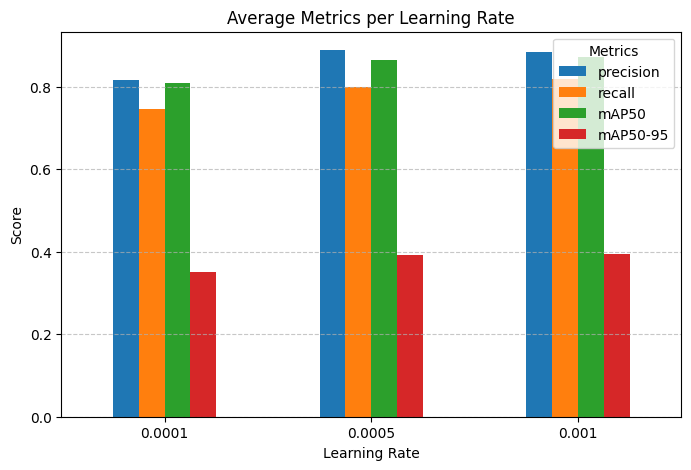

In [11]:
df_mean.set_index('lr', inplace=True)

df_mean.plot(kind='bar', figsize=(8,5))

plt.title("Average Metrics per Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Score")
plt.legend(title="Metrics")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [12]:
df_mean = df_results.groupby("lr")[["precision", "recall", "mAP50", "mAP50-95"]].mean().reset_index()
df_mean["metrics mean"] = (df_mean["precision"] + df_mean["recall"] + df_mean["mAP50"] + df_mean["mAP50-95"]) / 4
print(df_mean)
best_lr = df_mean.loc[df_mean["metrics mean"].idxmax(), "lr"]
print("Best learning rate based on metrics mean:", best_lr)

       lr  precision    recall     mAP50  mAP50-95  metrics mean
0  0.0001   0.817513  0.744903  0.808140  0.350910      0.680367
1  0.0005   0.888903  0.798900  0.865357  0.392103      0.736316
2  0.0010   0.883393  0.818570  0.873203  0.393943      0.742277
Best learning rate based on metrics mean: 0.001


In [13]:
lr = float(best_lr)
weights_path = "yolov8n.pt"
dataset_yaml = "data.yaml"
project= "best_lr_model"

batch = 10
epochs = 50
device = "cuda" if torch.cuda.is_available() else "cpu"

model = YOLO(weights_path, task="detect")

results = model.train(
    data=dataset_yaml,
    epochs=epochs,
    batch=batch,
    device=device,
    project=project,
    optimizer="Adam",
    lr0=lr,
    name=f"best_model_lr_{best_lr}"
)

New https://pypi.org/project/ultralytics/8.3.223 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.213 🚀 Python-3.12.3 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=10, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=best_model_lr_0.001, nbs=64, nms=

In [3]:
project_dir = "best_lr_model"
csv_path = glob.glob(os.path.join(project_dir, "**", "results.csv"), recursive=True)
csv_path = csv_path[0]
df = pd.read_csv(csv_path)

# Mejor epoch según mAP50-95
best_idx = df["metrics/mAP50-95(B)"].idxmax()
best_row = df.loc[best_idx]

print("Summary Best Epoch")
print(f"Epoch: {best_idx + 1}")
print(f"Precision: {best_row['metrics/precision(B)']:.4f}")
print(f"Recall: {best_row['metrics/recall(B)']:.4f}")
print(f"mAP50: {best_row['metrics/mAP50(B)']:.4f}")
print(f"mAP50-95: {best_row['metrics/mAP50-95(B)']:.4f}")

print("\nTraining Metrics")
print(f"Total epochs: {len(df)}")
print(f"Mean Precision: {df['metrics/precision(B)'].mean():.4f}")
print(f"Mean Recall: {df['metrics/recall(B)'].mean():.4f}")
print(f"Mean mAP50: {df['metrics/mAP50(B)'].mean():.4f}")
print(f"Mean mAP50-95: {df['metrics/mAP50-95(B)'].mean():.4f}")

Summary Best Epoch
Epoch: 47
Precision: 0.9118
Recall: 0.8713
mAP50: 0.9190
mAP50-95: 0.4513

Training Metrics
Total epochs: 50
Mean Precision: 0.8684
Mean Recall: 0.8158
Mean mAP50: 0.8599
Mean mAP50-95: 0.4022


In [5]:
best_model_path = f"best_lr_model/best_model_lr_0.001/weights/best.pt"
print(best_model_path)
test_yaml = "data.yaml"
test_results_folder = Path("test_results_best_model")
test_results_folder.mkdir(exist_ok=True, parents=True)

model = YOLO(best_model_path)

results = model.val(
    data=test_yaml,
    split="test",
    save_json=True,
    save_txt=True,
    project=test_results_folder.as_posix(),
    name="best_model_test_eval",
    verbose=True 
)

best_lr_model/best_model_lr_0.001/weights/best.pt
Ultralytics 8.3.213 🚀 Python-3.12.3 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4243.7±1165.5 MB/s, size: 270.8 KB)
val: Scanning /home/vinbu/University/Semester_8/Unit_2_Ai/AI_Solemne_2/dataset_yolo/test/labels.cache... 196 images, 24 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 196/196 400.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 2.5it/s 5.1s<1.3s
                   all        196        396      0.904      0.824      0.877      0.428
                  head        152        199      0.904      0.834      0.871      0.398
                  tail        152        197      0.904      0.815      0.882      0.457
Speed: 1.5ms preprocess, 4.4ms inference, 0.0ms loss, 2.5ms postprocess per image
Saving /ho

In [6]:
metrics = results.results_dict
summary = {
    "precision": metrics.get("metrics/precision(B)", metrics.get("precision")),
    "recall": metrics.get("metrics/recall(B)", metrics.get("recall")),
    "mAP50": metrics.get("metrics/mAP50(B)", metrics.get("map50")),
    "mAP50-95": metrics.get("metrics/mAP50-95(B)", metrics.get("map"))
}

print("Test summary metrics:")
print(summary)

Test summary metrics:
{'precision': 0.9040278132786521, 'recall': 0.8244188002872512, 'mAP50': 0.8765027093895076, 'mAP50-95': 0.4277430994806036}


In [19]:
best_model_path = f"best_lr_model/best_model_lr_{lr}/weights/best.pt"
model = YOLO(best_model_path)
test_images_dir = "dataset_yolo/test/images"
output_dir = "results"
images_out_dir = os.path.join(output_dir, "label_images")
os.makedirs(images_out_dir, exist_ok=True)

all_counts = []

results = model.predict(source=test_images_dir, save=False, conf=0.25, verbose=False)

for result in results:
    img_path = result.path
    img_name = os.path.basename(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    class_ids = result.boxes.cls.tolist()
    names = result.names

    head_count = sum(names[int(c)] == "head" for c in class_ids)
    tail_count = sum(names[int(c)] == "tail" for c in class_ids)

    all_counts.append({
        "image": img_name,
        "head_count": head_count,
        "tail_count": tail_count,
        "total_detections": len(class_ids)
    })

    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        cls_id = int(box.cls[0])
        label = names[cls_id]

        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(img, label, (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

    cv2.putText(img, f"Heads: {head_count} | Tails: {tail_count}",
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                1, (255,0,0), 3)

    save_path = os.path.join(images_out_dir, img_name)
    cv2.imwrite(save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

df_counts = pd.DataFrame(all_counts)
csv_path = os.path.join(output_dir, "results.csv")
df_counts.to_csv(csv_path, index=False)
print(f"Saved in: {csv_path}")

Saved in: results/results.csv
